In [ ]:
import os
import cv2
import h5py
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statistics import mean
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, auc

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler, Sampler
from torch.optim import Adam, SGD
from torchvision import transforms, models
from torchvision.models import resnet18  
from torchvision.transforms import Resize, ToTensor
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from PIL import Image

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [2]:

file_path_1 = '/kaggle/input/common-task1/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
file_path_2 = '/kaggle/input/common-task1/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
with h5py.File(file_path_1, 'r') as file:
    print(list(file.keys()))
    
with h5py.File(file_path_2, 'r') as file:
    print(list(file.keys()))

['X', 'y']
['X', 'y']


In [3]:

with h5py.File(file_path_1, 'r') as file:
    X1 = file['X'][:]
    y1 = file['y'][:]
    
with h5py.File(file_path_2, 'r') as file:
    X2 = file['X'][:]
    y2 = file['y'][:]

In [4]:

X = np.concatenate([X1, X2])
y = np.concatenate([y1, y2])
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
X = X.astype('float32') / 255.0
X= X[:,:,:, 1:2]


Shape of X: (498000, 32, 32, 2)
Shape of y: (498000,)


In [5]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [7]:
class ResNet15(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet15, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return torch.sigmoid(out).squeeze(dim=1)


In [8]:

class DatasetLoader:
    def __init__(self, X_train, y_train, X_val, y_val, batch_size):
        self.batch_size = batch_size
        self.train_loader = self.create_dataloader(X_train, y_train, shuffle=True)
        self.val_loader = self.create_dataloader(X_val, y_val, shuffle=False)

    def create_dataloader(self, X, y, shuffle):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)# Change to long() if classification
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
batch_size = 256
dataset_loader = DatasetLoader(X_train, y_train, X_val, y_val, 256)

In [9]:

model = ResNet15(BasicBlock, [2, 2, 2]).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4) # Example value
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=5e-8, last_epoch=-1, verbose=True)

In [10]:

train_loss = []
val_loss = []
train_acc = []
val_acc = []
roc_auc_scores_train = []  
roc_auc_scores_val = []    
epoch_count = []

best_roc_auc = 0.0
best_model_state_dict = None
best_val_loss = float('inf')  # Initialize best validation loss
epochs_no_improve = 0  # Counter for early stopping
early_stopping_patience = 5  # Stop if no improvement for this many epochs
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    y_true = []
    y_scores = []

    model.train()
    with tqdm(dataset_loader.train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as train_loader_with_progress:
        for i, data in enumerate(train_loader_with_progress, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device).float()  # Convert labels to float for BCE loss
            optimizer.zero_grad()
            
            outputs = model(inputs.permute(0, 3, 1, 2))            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            predicted = ((outputs) > 0.5).float()  
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_scores.extend((outputs).cpu().detach().numpy())  

    train_loss.append(running_loss / len(dataset_loader.train_loader))
    train_accuracy = correct_predictions / total_predictions
    train_acc.append(train_accuracy)
    epoch_count.append(epoch + 1)
    roc_auc_train = roc_auc_score(y_true, y_scores)
    roc_auc_scores_train.append(roc_auc_train)

    # --- Validation Phase ---
    model.eval()
    val_running_loss = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    y_true_val = []
    y_scores_val = []

    with torch.no_grad():
        for inputs_val, labels_val in dataset_loader.val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device).float()  
            
            outputs_val = model(inputs_val.permute(0, 3, 1, 2))
            val_loss_batch = criterion(outputs_val, labels_val)
            val_running_loss += val_loss_batch.item()

            predicted_val = ((outputs_val) > 0.5).float()  
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            total_predictions_val += labels_val.size(0)

            y_true_val.extend(labels_val.cpu().numpy())
            y_scores_val.extend((outputs_val).cpu().detach().numpy())  

    val_loss_epoch = val_running_loss / len(dataset_loader.val_loader)
    val_loss.append(val_loss_epoch)
    val_accuracy = correct_predictions_val / total_predictions_val
    val_acc.append(val_accuracy)
    roc_auc_val = roc_auc_score(y_true_val, y_scores_val)
    roc_auc_scores_val.append(roc_auc_val)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss_epoch:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Train ROC-AUC: {roc_auc_train:.3f}, Val ROC-AUC: {roc_auc_val:.3f}")

    scheduler.step()

    # --- Early Stopping Logic ---
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        epochs_no_improve = 0  # Reset counter
        best_model_state_dict = model.state_dict()
        torch.save(best_model_state_dict, "model_weights_Common_Task_1.pth")
# Save best model
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epochs.")

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break  # Stop training

print("Finished training.")

Epoch 1, Train Loss: 0.6771, Val Loss: 0.6773, Train Acc: 0.5760, Val Acc: 0.5802, Train ROC-AUC: 0.599, Val ROC-AUC: 0.606


Epoch 2, Train Loss: 0.6727, Val Loss: 0.6710, Train Acc: 0.5857, Val Acc: 0.5904, Train ROC-AUC: 0.612, Val ROC-AUC: 0.617


Epoch 3, Train Loss: 0.6704, Val Loss: 0.6774, Train Acc: 0.5906, Val Acc: 0.5861, Train ROC-AUC: 0.618, Val ROC-AUC: 0.620
No improvement in validation loss for 1 epochs.


Epoch 4, Train Loss: 0.6679, Val Loss: 0.6721, Train Acc: 0.5952, Val Acc: 0.5896, Train ROC-AUC: 0.625, Val ROC-AUC: 0.625
No improvement in validation loss for 2 epochs.


Epoch 5, Train Loss: 0.6643, Val Loss: 0.6634, Train Acc: 0.6016, Val Acc: 0.6047, Train ROC-AUC: 0.635, Val ROC-AUC: 0.639


Epoch 6, Train Loss: 0.6593, Val Loss: 0.6962, Train Acc: 0.6087, Val Acc: 0.4995, Train ROC-AUC: 0.647, Val ROC-AUC: 0.513
No improvement in validation loss for 1 epochs.


Epoch 7, Train Loss: 0.6546, Val Loss: 0.6812, Train Acc: 0.6154, Val Acc: 0.5594, Train ROC-AUC: 0.657, Val ROC-AUC: 0.603
No improvement in validation loss for 2 epochs.


Epoch 8, Train Loss: 0.6504, Val Loss: 0.6561, Train Acc: 0.6212, Val Acc: 0.6137, Train ROC-AUC: 0.665, Val ROC-AUC: 0.657


Epoch 9, Train Loss: 0.6467, Val Loss: 0.6901, Train Acc: 0.6266, Val Acc: 0.5276, Train ROC-AUC: 0.672, Val ROC-AUC: 0.595
No improvement in validation loss for 1 epochs.


Epoch 10, Train Loss: 0.6434, Val Loss: 0.6514, Train Acc: 0.6305, Val Acc: 0.6231, Train ROC-AUC: 0.677, Val ROC-AUC: 0.666


Epoch 11, Train Loss: 0.6402, Val Loss: 0.7252, Train Acc: 0.6346, Val Acc: 0.5043, Train ROC-AUC: 0.683, Val ROC-AUC: 0.633
No improvement in validation loss for 1 epochs.


Epoch 12, Train Loss: 0.6370, Val Loss: 0.6516, Train Acc: 0.6381, Val Acc: 0.6195, Train ROC-AUC: 0.688, Val ROC-AUC: 0.665
No improvement in validation loss for 2 epochs.


Epoch 13, Train Loss: 0.6331, Val Loss: 0.6509, Train Acc: 0.6426, Val Acc: 0.6225, Train ROC-AUC: 0.694, Val ROC-AUC: 0.667


Epoch 14, Train Loss: 0.6291, Val Loss: 0.6536, Train Acc: 0.6466, Val Acc: 0.6223, Train ROC-AUC: 0.700, Val ROC-AUC: 0.667
No improvement in validation loss for 1 epochs.


Epoch 15, Train Loss: 0.6244, Val Loss: 0.6546, Train Acc: 0.6506, Val Acc: 0.6215, Train ROC-AUC: 0.707, Val ROC-AUC: 0.664
No improvement in validation loss for 2 epochs.


Epoch 16, Train Loss: 0.6197, Val Loss: 0.6617, Train Acc: 0.6562, Val Acc: 0.6141, Train ROC-AUC: 0.713, Val ROC-AUC: 0.659
No improvement in validation loss for 3 epochs.


Epoch 17, Train Loss: 0.6157, Val Loss: 0.6627, Train Acc: 0.6601, Val Acc: 0.6113, Train ROC-AUC: 0.719, Val ROC-AUC: 0.652
No improvement in validation loss for 4 epochs.


Epoch 18, Train Loss: 0.6122, Val Loss: 0.6634, Train Acc: 0.6638, Val Acc: 0.6161, Train ROC-AUC: 0.723, Val ROC-AUC: 0.658
No improvement in validation loss for 5 epochs.
Early stopping triggered after 18 epochs!
Finished training.


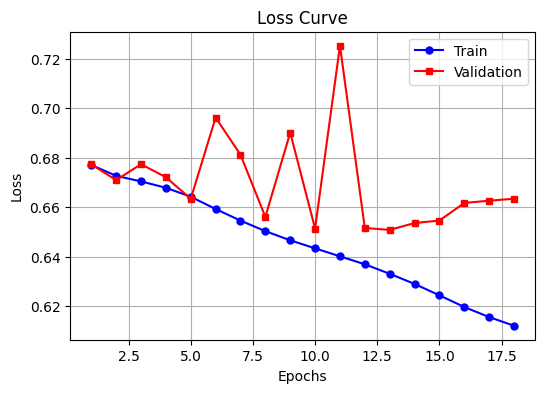

In [11]:
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(6, 4)) 
plt.plot(epochs, train_loss, 'bo-', label='Train', markersize=5, linewidth=1.5)  # Blue with circles
plt.plot(epochs, val_loss, 'rs-', label='Validation', markersize=5, linewidth=1.5)  # Red with squares
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


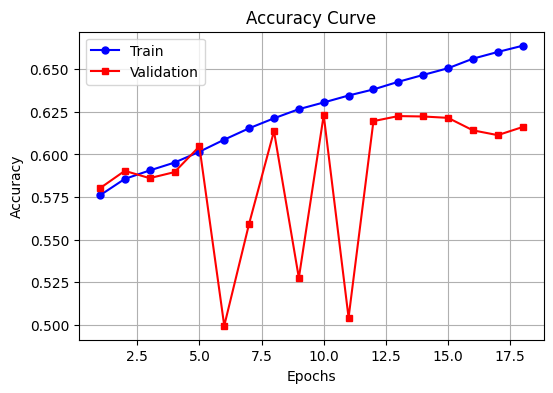

In [12]:
epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, 'bo-', label='Train', markersize=5, linewidth=1.5)
plt.plot(epochs, val_acc, 'rs-', label='Validation', markersize=5, linewidth=1.5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

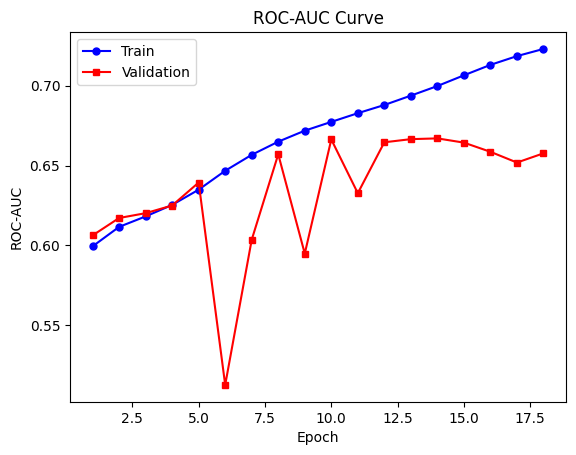

In [13]:
plt.plot(epochs, roc_auc_scores_train, 'bo-', label='Train', markersize=5, linewidth=1.5)
plt.plot(epochs, roc_auc_scores_val, 'rs-', label='Validation', markersize=5, linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()


In [14]:
checkpoint = torch.load("/kaggle/working/model_weights_Common_Task_1.pth")
model = ResNet15(BasicBlock, [2, 2, 2]).to(device)
model.load_state_dict(checkpoint)
model.eval()

test_running_loss = 0.0
correct_predictions_test = 0
total_predictions_test = 0
y_true_test = []
y_scores_test = []

with torch.no_grad():
    for inputs_test, labels_test in dataset_loader.val_loader:
        inputs_test = inputs_test.to(device)
        # Convert labels to float, matching training if necessary
        labels_test = labels_test.to(device).float()
        
        # Permute input dimensions from (B, 32, 32, 2) to (B, 2, 32, 32)
        outputs_test = model(inputs_test.permute(0, 3, 1, 2))
        
        # Option 1: Squeeze if needed to get [batch] shape
        if outputs_test.dim() == 2 and outputs_test.size(1) == 1:
            outputs_test = outputs_test.squeeze(1)
        
        test_loss_batch = criterion(outputs_test, labels_test)
        test_running_loss += test_loss_batch.item()
        
        predicted_test = (outputs_test > 0.5).float()
        correct_predictions_test += (predicted_test == labels_test).sum().item()
        total_predictions_test += labels_test.size(0)
        
        y_true_test.extend(labels_test.cpu().numpy())
        y_scores_test.extend(outputs_test.cpu().detach().numpy())

# Use the val_loader length for computing average loss
test_loss = test_running_loss / len(dataset_loader.val_loader)
test_accuracy = correct_predictions_test / total_predictions_test
roc_auc_test = roc_auc_score(y_true_test, y_scores_test)
accuracy_test = accuracy_score(y_true_test, (np.array(y_scores_test) > 0.5))

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test ROC-AUC: {roc_auc_test:.4f}")

Test Loss: 0.6509, Test Accuracy: 0.6225, Test ROC-AUC: 0.6665



--- Generating ROC Curve ---


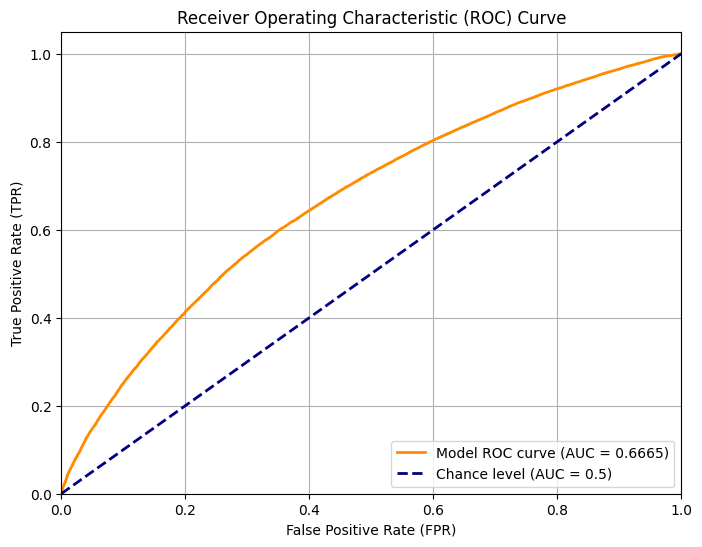

In [ ]:

fpr, tpr, thresholds = roc_curve(y_true_test, y_scores_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Model ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
